<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/10_TC1_Cluster_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [82]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [83]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1


In [85]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')


In [86]:
TC1data15['project_id_name'] = outcome['Project_id_name']
TC1data15['project_id'] = outcome['Project_id']

In [87]:
TC1data15_cluster = TC1data15.copy()
TC1data15_cluster['project_id_name'] = TC1data15_cluster['project_id_name'].replace(['TCGA-CESC','TCGA-LUSC','TCGA-BLCA','TCGA-HNSC'],'SCC')
TC1data15_cluster['project_id'] = TC1data15_cluster['project_id'].replace([0,2,4,9],0)

cluster_300 = TC1data15_cluster[(TC1data15_cluster['project_id_name'] == 'SCC')].copy().sample(n = 300)
TC1data15_reduced = TC1data15_cluster[(TC1data15_cluster['project_id_name'] != 'SCC')].copy()
TC1data15_reduced = TC1data15_reduced.append(cluster_300)

TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([13],2)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([14],4)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([15],9)
TC1data15 = TC1data15_reduced.copy()


In [88]:
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.000000,1.644513,1.765476,2.090856,0.549029,0.718534,0.000000,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.000000,2.098755,1.643610,2.391891,0.884490,0.000000,0.000000,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.000000,1.567345,1.350662,2.029576,0.246144,2.193634,0.000000,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.000000,1.955291,1.635719,2.151499,0.000000,1.956215,0.000000,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.000000,2.429317,1.840638,2.187733,0.238939,1.196076,0.000000,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,1.436697,0.000000,1.976367,0.984313,1.373501,1.258927,1.406441,1.638964,1.916843,1.647613,0.599702,1.371494,1.496418,1.528773,1.953505,0.000000,1.607703,0.669902,1.281840,0.874215,0.000000,2.129609,2.074576,2.086371,0.868416,0.629826,0.000000,0.0,1.177889,2.338158,1.469933,1.182773,1.932667,0.833442,0.496279,0.783358,0.908048,1.219

In [89]:
# from keras.utils import to_categorical
outcome = TC1data15.loc[:,['project_id','project_id_name']]
TC1data15 = TC1data15.iloc[:,:-2]

TC1data15.shape, outcome.shape

((3600, 60483), (3600, 2))

In [90]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [91]:
# outcome = encode(outcome['Project_id'])

# Random Forest

In [92]:
np.random.seed(123)
# define the model
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# fit the model
model.fit(TC1data15, outcome['project_id'])



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [93]:
# get importance
importance = model.feature_importances_


In [94]:
feature = pd.DataFrame()
feature['name'] = TC1data15.columns

In [95]:
feature['importance'] = importance
feature

,name,importance
0,TSPAN6,0.000000
1,TNMD,0.000017
2,DPM1,0.000006
3,SCYL3,0.000000
4,C1orf112,0.000000
...,...,...
60478,Metazoa_SRP.305,0.000000
60479,AJ271736.1.1,0.000000
60480,MIR6089.1,0.000000
60481,RP13-465B17.5.1,0.000000


In [96]:
feature_sort = feature.sort_values(by='importance',ascending=False)


# ConvNN(RF) - top 150

## Train/Test split    

In [97]:
# from keras.utils import to_categorical
outcome = encode(outcome['project_id'])

Shape of data (BEFORE encode): (3600,)
Shape of data (AFTER  encode): (3600, 13)



In [98]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.001]
feature_sort_selected = feature_sort.iloc[:150,:]
feature_sort_selected

,name,importance
55243,RP11-53M11.5,0.004653
5677,PAX8,0.003128
520,DAPK2,0.003098
55519,FP236383.3,0.003058
195,NOX1,0.002905
...,...,...
271,FYN,0.001108
55791,CCL16,0.001096
48804,LINC00675,0.001096
54958,RP11-174N3.4,0.001089


In [99]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [101]:
X_train

,RP11-53M11.5,PAX8,DAPK2,FP236383.3,NOX1,RPL23AP12,DOCK3,FP671120.7,TMEFF2,SOX17,KLK4,KLKP1,F13B,CLRN3,CDX1,KLHL14,VSTM4,RDH11,AL161626.1,KCNJ16,AC012123.1,SFTA3,ACSM2A,SLC17A1,NKX2-1,CRYGN,LINC00483,FAM83C,RP4-797C5.2,ALDH8A1,HNF1A,MAP1A,AC079949.1,GPM6B,LMO3,AZGP1,DNER,RP11-548P2.2,ZDHHC22,NLGN3,...,CDK18,CYP2S1,MEIS1,ABCG8,GGTLC1,NPC2,STK32A,CH507-513H4.5,AP000439.3,S1PR5,POF1B,LINC00958,AC021218.2,UQCRFS1P1,RP11-554A11.7,CDX2,MTFR2,DSCAM,RNLS,GJB5,SLC1A3,PMEPA1,PPAP2B,DPP6,RP11-349K16.1,GUCY2C,RP11-25I15.1,LYPLAL1,HAGLROS,NKX2-1-AS1,AP1M2,ATP10B,RP11-777B9.5,SLC6A13,FP236383.10,FYN,CCL16,LINC00675,RP11-174N3.4,RP11-1220K2.2
78,0.776733,2.046322,0.116359,3.745806,0.000000,0.794178,0.000000,3.122111,0.0,2.291502,0.00000,0.0,0.0,0.000000,0.000000,1.251182,0.242874,1.234342,3.313982,0.342990,0.901882,0.000000,0.000000,0.000000,0.000000,0.065073,0.000000,0.0,1.249566,0.252722,0.000000,0.712726,3.151820,0.895281,0.282701,0.183964,0.000000,0.000000,0.0,0.000000,...,1.251255,1.402243,1.311645,0.0,0.0,2.326341,0.000000,2.153172,0.000000,0.000000,0.653221,1.119973,0.000000,0.767032,0.0,0.000000,0.788658,0.0,1.052470,0.000000,1.547510,1.364381,1.197917,0.0,0.000000,0.000000,1.191023,1.178711,1.809359,0.000000,2.257035,0.000000,1.168359,0.354203,3.668302,1.109324,0.000000,0.000000,0.769028,0.000000
1425,0.000000,1.519381,0.308121,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.729324,0.00000,0.0,0.0,2.194229,0.000000,0.000000,1.094152,1.444894,0.000000,1.953316,0.000000,0.000000,1.567086,1.111021,0.000000,0.000000,0.000000,0.0,0.000000,2.154374,1.391757,0.623489,0.120320,0.000000,0.000000,0.612309,1.282984,0.000000,0.0,0.000000,...,2.426494,0.357227,0.147046,0.0,0.0,2.305488,0.577615,0.000000,1.115629,0.109348,0.000000,1.522827,0.768711,0.000000,0.0,0.000000,0.540107,0.0,1.599116,0.536647,0.888159,1.300013,2.189696,0.0,0.000000,0.174408,0.000000,1.626220,0.780832,0.000000,1.669951,0.000000,0.327191,2.245252,0.000000,1.218239,0.000000,0.000000,0.000000,0.000000
118,0.000000,0.000000,0.178394,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.017363,0.00000,0.0,0.0,0.000000,0.603540,0.000000,1.106028,1.685937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209883,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.737802,0.000000,0.661726,0.000000,0.534326,0.000000,0.000000,0.0,0.000000,...,1.601479,2.328956,0.499169,0.0,0.0,2.555174,0.000000,0.097237,0.000000,0.579187,0.845422,1.015799,0.084258,0.000000,0.0,0.000000,0.557879,0.0,0.799030,1.980148,1.063324,2.199145,1.516688,0.0,0.000000,0.140544,0.000000,1.270502,0.782866,0.000000,1.599343,0.000000,0.000000,0.000000,0.000000,0.996474,0.000000,0.000000,0.000000,0.000000
3076,0.000000,2.512828,2.126678,0.363193,0.070160,0.000000,1.557641,0.000000,0.0,0.771178,0.00000,0.0,0.0,0.163872,0.000000,1.400028,2.016141,1.705726,0.000000,2.459444,0.671569,2.160646,0.000000,0.000000,2.409727,1.815649,0.000000,0.0,0.000000,0.000000,0.000000,0.381554,0.179415,0.092482,2.095735,0.000000,0.000000,0.964285,0.0,0.000000,...,1.268566,1.476803,0.000000,0.0,0.0,3.453797,1.588416,0.000000,0.000000,0.000000,0.000000,1.096263,0.000000,0.000000,0.0,0.000000,0.083943,0.0,1.047710,0.629426,0.639428,1.577712,2.801420,0.0,0.000000,0.000000,0.187102,1.373209,0.000000,1.309341,2.319642,0.116092,0.000000,0.631899,0.000000,1.946826,0.000000,0.000000,0.000000,0.000000
2536,0.000000,0.000000,0.814388,0.392136,0.000616,0.000000,0.000000,0.000000,0.0,0.556067,0.00000,0.0,0.0,0.000000,0.000000,0.000000,1.261321,1.078878,0.685479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802144,0.000000,0.0,0.071343,0.000000,0.000000,1.687360,0.000000,0.000000,0.920295,0.218771,0.000000,0.000000,0.0,0.000000,...,1.533726,0.062048,0.325127,0.0,0.0,2.783743,0.000000,0.642483,0.000000,0.118205,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.455868,0.000000,0.000000,0.672455,1.311143,0.0,0.000000,0.000000,0.000000,1.367412,0.000000,0.000000,1.115292,0.000000,0.017289,0.757340,0.000000,0.840601,0.154050,0.00

## CONV1D 

In [102]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [103]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [104]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 131, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 131, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 122, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

In [105]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [106]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [107]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 7s 47ms/step - loss: 1.6715 - acc: 0.4596 - val_loss: 0.1171 - val_acc: 0.9689

Epoch 00001: val_loss improved from inf to 0.11714, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 6s 45ms/step - loss: 0.1479 - acc: 0.9560 - val_loss: 0.0704 - val_acc: 0.9800

Epoch 00002: val_loss improved from 0.11714 to 0.07045, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 6s 45ms/step - loss: 0.0882 - acc: 0.9798 - val_loss: 0.0779 - val_acc: 0.9778

Epoch 00003: val_loss did not improve from 0.07045
Epoch 4/30
135/135 [==============================] - 6s 46ms/step - loss: 0.0516 - acc: 0.9848 - val_loss: 0.0695 - val_acc: 0.9844

Epoch 00004: val_loss improved from 0.07045 to 0.06950, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 5/30
1

In [108]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0953412726521492
Test accuracy: 0.9855555295944214


Text(0.5, 0, 'epoch')

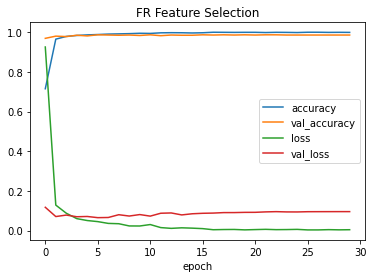

In [109]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [110]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [111]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [112]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.0953412726521492
Test accuracy: 0.9855555295944214
accuracy: 98.56%


# ConvNN(RF) - top 500

## Train/Test split    

In [113]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [114]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.0005]
feature_sort_selected = feature_sort.iloc[:500,:]
feature_sort_selected

,name,importance
55243,RP11-53M11.5,0.004653
5677,PAX8,0.003128
520,DAPK2,0.003098
55519,FP236383.3,0.003058
195,NOX1,0.002905
...,...,...
10805,VCAM1,0.000655
19650,FAM83H-AS1,0.000654
27103,AC010970.2,0.000654
26523,TMEM233,0.000653


In [115]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [117]:
X_train

,RP11-53M11.5,PAX8,DAPK2,FP236383.3,NOX1,RPL23AP12,DOCK3,FP671120.7,TMEFF2,SOX17,KLK4,KLKP1,F13B,CLRN3,CDX1,KLHL14,VSTM4,RDH11,AL161626.1,KCNJ16,AC012123.1,SFTA3,ACSM2A,SLC17A1,NKX2-1,CRYGN,LINC00483,FAM83C,RP4-797C5.2,ALDH8A1,HNF1A,MAP1A,AC079949.1,GPM6B,LMO3,AZGP1,DNER,RP11-548P2.2,ZDHHC22,NLGN3,...,FAM3D,ZNF761,SCGB2A2,GPRC5A,GLYCTK,C12orf49,FOXA2,SKA1,CCAT1,DGAT2,UPB1,PDX1,CAPN8,TIMM8AP1,PPIAP22,CX3CR1,PTGS1,CEP55,C4orf32,LURAP1,TMEM243,TMEM174,SEC14L2,LRRN2,APLP2,HNRNPA1P27,APOF,PCSK2,PLEK2,CYP4A22,RP11-353M9.1,RP5-1056H1.2,LINC01485,EMID1,NAP1L2,VCAM1,FAM83H-AS1,AC010970.2,TMEM233,WDR91
78,0.776733,2.046322,0.116359,3.745806,0.000000,0.794178,0.000000,3.122111,0.0,2.291502,0.00000,0.0,0.0,0.000000,0.000000,1.251182,0.242874,1.234342,3.313982,0.342990,0.901882,0.000000,0.000000,0.000000,0.000000,0.065073,0.000000,0.0,1.249566,0.252722,0.000000,0.712726,3.151820,0.895281,0.282701,0.183964,0.000000,0.000000,0.0,0.000000,...,0.000000,0.498326,0.572644,1.158797,0.475356,0.900536,0.000000,0.801502,0.000000,0.502740,0.000000,0.000000,0.000000,0.233300,2.013071,0.885179,1.905567,1.690071,0.164461,0.000000,1.080536,0.000000,0.635752,1.239659,2.203528,0.000000,0.0,0.000000,0.799219,0.000000,0.094291,0.000000,0.000000,0.916557,0.000000,1.027233,0.686582,2.767932,0.000000,1.479767
1425,0.000000,1.519381,0.308121,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.729324,0.00000,0.0,0.0,2.194229,0.000000,0.000000,1.094152,1.444894,0.000000,1.953316,0.000000,0.000000,1.567086,1.111021,0.000000,0.000000,0.000000,0.0,0.000000,2.154374,1.391757,0.623489,0.120320,0.000000,0.000000,0.612309,1.282984,0.000000,0.0,0.000000,...,0.000000,0.838289,0.000000,0.187898,0.800316,1.220191,0.000000,0.427562,0.000000,0.635349,0.874722,0.000000,0.000000,0.000000,2.275528,0.575758,1.869543,0.855669,0.503097,0.465417,1.800531,1.199131,0.763773,0.193652,2.636559,0.000000,0.0,0.000000,1.219036,0.000000,0.000000,0.000000,0.088734,0.510370,0.676480,2.298061,0.730739,0.000000,0.811405,1.621943
118,0.000000,0.000000,0.178394,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.017363,0.00000,0.0,0.0,0.000000,0.603540,0.000000,1.106028,1.685937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209883,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.737802,0.000000,0.661726,0.000000,0.534326,0.000000,0.000000,0.0,0.000000,...,0.235775,0.888125,0.000000,1.587883,0.578587,1.256481,0.000000,0.808636,0.964304,0.728808,0.000000,0.000000,0.000000,0.000000,2.533183,0.000000,0.981001,1.518312,0.175791,0.408288,1.086276,0.000000,1.067529,0.512134,2.254973,0.000000,0.0,0.000000,1.505323,0.000000,0.000000,0.100943,0.000000,1.014686,0.002686,1.092925,1.524440,0.000000,0.000000,1.558950
3076,0.000000,2.512828,2.126678,0.363193,0.070160,0.000000,1.557641,0.000000,0.0,0.771178,0.00000,0.0,0.0,0.163872,0.000000,1.400028,2.016141,1.705726,0.000000,2.459444,0.671569,2.160646,0.000000,0.000000,2.409727,1.815649,0.000000,0.0,0.000000,0.000000,0.000000,0.381554,0.179415,0.092482,2.095735,0.000000,0.000000,0.964285,0.0,0.000000,...,0.010481,0.963900,0.000000,2.336307,0.695590,2.315562,0.218786,0.000000,0.000000,0.876237,0.000000,0.000000,0.000000,0.827196,2.128761,0.370226,0.803039,0.485067,0.614240,1.204370,1.862932,0.000000,1.435147,0.557442,3.258653,1.085620,0.0,1.595388,1.891575,0.000000,0.000000,0.000000,0.000000,1.026220,1.257915,0.773743,0.885614,0.000000,1.843219,0.954858
2536,0.000000,0.000000,0.814388,0.392136,0.000616,0.000000,0.000000,0.000000,0.0,0.556067,0.00000,0.0,0.0,0.000000,0.000000,0.000000,1.261321,1.078878,0.685479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802144,0.000000,0.0,0.071343,0.000000,0.000000,1.687360,0.000000,0.000000,0.920295,0.218771,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.235171,0.599177,0.536388,0.000000,0.152422,0.000000,0.164974,0.000000,0.000000,0.000000,1.132900,1.686132,0.000000,0.190559,0.093005,0.695582,0.000000,0.220404,0.000000,0.000000,1.269371,2.120955,0.000000,0.0,0.000000,0.361359,0.000000,0.0

## CONV1D 

In [118]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [119]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [120]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 481, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 481, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 481, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 472, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 472, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 47, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6016)              0

In [121]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [122]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [123]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 19s 134ms/step - loss: 1.8040 - acc: 0.3995 - val_loss: 0.1618 - val_acc: 0.9600

Epoch 00001: val_loss improved from inf to 0.16176, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 18s 131ms/step - loss: 0.1441 - acc: 0.9611 - val_loss: 0.0888 - val_acc: 0.9778

Epoch 00002: val_loss improved from 0.16176 to 0.08876, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 18s 132ms/step - loss: 0.0872 - acc: 0.9807 - val_loss: 0.0826 - val_acc: 0.9811

Epoch 00003: val_loss improved from 0.08876 to 0.08262, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 18s 131ms/step - loss: 0.0688 - acc: 0.9813 - val_loss: 0.0707 - val_acc: 0.9856

Epoch 00004: val_loss improved from 0.08262 to 0.07071,

In [124]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09131346642971039
Test accuracy: 0.9900000095367432


Text(0.5, 0, 'epoch')

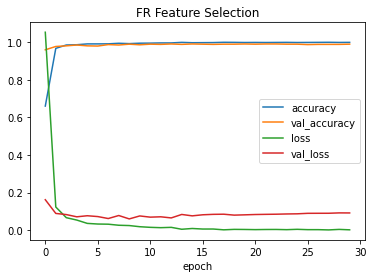

In [125]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [126]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [127]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [128]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.09131346642971039
Test accuracy: 0.9900000095367432
accuracy: 99.00%


# ConvNN(RF) - top 300

## Train/Test split    

In [129]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [130]:
feature_sort_selected = feature_sort.iloc[:300,:]
feature_sort_selected

,name,importance
55243,RP11-53M11.5,0.004653
5677,PAX8,0.003128
520,DAPK2,0.003098
55519,FP236383.3,0.003058
195,NOX1,0.002905
...,...,...
543,HOXC8,0.000809
386,VSIG2,0.000809
34576,ZNF853,0.000808
44201,RP11-234B24.2,0.000808


In [131]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [133]:
X_train

,RP11-53M11.5,PAX8,DAPK2,FP236383.3,NOX1,RPL23AP12,DOCK3,FP671120.7,TMEFF2,SOX17,KLK4,KLKP1,F13B,CLRN3,CDX1,KLHL14,VSTM4,RDH11,AL161626.1,KCNJ16,AC012123.1,SFTA3,ACSM2A,SLC17A1,NKX2-1,CRYGN,LINC00483,FAM83C,RP4-797C5.2,ALDH8A1,HNF1A,MAP1A,AC079949.1,GPM6B,LMO3,AZGP1,DNER,RP11-548P2.2,ZDHHC22,NLGN3,...,RNA5SP301,EPN3,OR51E2,PLG,RP13-514E23.1,SCHIP1,F10,F9,RP11-3P17.5,AARD,GRHL2,U47924.27,SCN3A,APCS,CCNB2,PDLIM5,NDUFA4L2,TFR2,SYT11,CMTM5,ESRP1,AC106876.2,ORM1,AP001187.9,PRR36,POU3F4,APOE,NLRP1,ACSM2B,PCA3,C2orf80,FGFR4,CACNB3,APOA2,FAAH,HOXC8,VSIG2,ZNF853,RP11-234B24.2,ADCY2
78,0.776733,2.046322,0.116359,3.745806,0.000000,0.794178,0.000000,3.122111,0.0,2.291502,0.00000,0.0,0.0,0.000000,0.000000,1.251182,0.242874,1.234342,3.313982,0.342990,0.901882,0.000000,0.000000,0.000000,0.000000,0.065073,0.000000,0.0,1.249566,0.252722,0.000000,0.712726,3.151820,0.895281,0.282701,0.183964,0.000000,0.000000,0.0,0.000000,...,0.018277,1.499189,0.00000,0.0,0.000000,0.000000,0.224894,0.0,1.998867,0.920082,0.922816,1.762018,0.000000,0.000000,1.841458,1.345645,1.242924,0.000000,0.719523,0.0,1.744177,0.000000,0.000000,0.000000,0.715359,0.0,3.056126,0.260753,0.000000,0.0,0.0,0.063935,0.719330,0.000000,0.982611,0.517971,0.783968,0.977710,0.000000,0.000000
1425,0.000000,1.519381,0.308121,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.729324,0.00000,0.0,0.0,2.194229,0.000000,0.000000,1.094152,1.444894,0.000000,1.953316,0.000000,0.000000,1.567086,1.111021,0.000000,0.000000,0.000000,0.0,0.000000,2.154374,1.391757,0.623489,0.120320,0.000000,0.000000,0.612309,1.282984,0.000000,0.0,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1.406566,0.0,0.627871,0.201388,0.000000,0.000000,0.000000,0.324557,0.885248,1.647306,3.192313,0.000000,1.260667,0.0,0.000000,0.045285,0.000000,0.000000,0.000000,0.0,2.913896,0.375095,1.769023,0.0,0.0,1.782175,0.714553,0.000000,1.623667,1.429267,0.000000,0.253733,0.000000,0.455689
118,0.000000,0.000000,0.178394,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.017363,0.00000,0.0,0.0,0.000000,0.603540,0.000000,1.106028,1.685937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209883,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.737802,0.000000,0.661726,0.000000,0.534326,0.000000,0.000000,0.0,0.000000,...,0.000000,0.899373,0.00000,0.0,0.000000,0.000000,0.616835,0.0,0.000000,0.000000,1.145925,2.116796,0.000000,0.000000,1.708158,1.480404,2.725614,0.475499,0.996320,0.0,1.865981,0.000000,0.432225,0.000000,0.000000,0.0,1.876119,0.618763,0.000000,0.0,0.0,0.269437,0.941237,0.000000,0.732963,0.962298,0.098381,0.658667,0.000000,0.320582
3076,0.000000,2.512828,2.126678,0.363193,0.070160,0.000000,1.557641,0.000000,0.0,0.771178,0.00000,0.0,0.0,0.163872,0.000000,1.400028,2.016141,1.705726,0.000000,2.459444,0.671569,2.160646,0.000000,0.000000,2.409727,1.815649,0.000000,0.0,0.000000,0.000000,0.000000,0.381554,0.179415,0.092482,2.095735,0.000000,0.000000,0.964285,0.0,0.000000,...,0.000000,0.746429,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.017960,0.000000,1.484751,1.628011,0.000000,0.000000,0.593487,1.496740,1.264629,0.000000,0.981627,0.0,1.839214,0.000000,0.000000,0.000000,1.277571,0.0,3.095536,1.246524,0.000000,0.0,0.0,0.000000,1.056463,0.000000,1.528499,0.000000,2.021267,1.391419,0.000000,0.000000
2536,0.000000,0.000000,0.814388,0.392136,0.000616,0.000000,0.000000,0.000000,0.0,0.556067,0.00000,0.0,0.0,0.000000,0.000000,0.000000,1.261321,1.078878,0.685479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802144,0.000000,0.0,0.071343,0.000000,0.000000,1.687360,0.000000,0.000000,0.920295,0.218771,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,3.160822,0.0,0.444842,0.000000,0.000000,0.000000,0.107829,0.452466,0.184372,0.650890,1.502693,0.000000,0.000000,0.0,0.000000,0.000000,1.263572,0.000000,0.000000,0.0,4.460532,0.532530,0.000000,0.0,0.0,0.000000,0.313864,1.203645,1.283492,0.020439,0.489531,0.081274,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## CONV1D 

In [134]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [135]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [136]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [137]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [138]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [139]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 12s 87ms/step - loss: 1.7473 - acc: 0.4448 - val_loss: 0.1361 - val_acc: 0.9689

Epoch 00001: val_loss improved from inf to 0.13605, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 11s 85ms/step - loss: 0.1338 - acc: 0.9613 - val_loss: 0.0827 - val_acc: 0.9789

Epoch 00002: val_loss improved from 0.13605 to 0.08272, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 11s 84ms/step - loss: 0.0732 - acc: 0.9826 - val_loss: 0.0901 - val_acc: 0.9778

Epoch 00003: val_loss did not improve from 0.08272
Epoch 4/30
135/135 [==============================] - 11s 84ms/step - loss: 0.0541 - acc: 0.9866 - val_loss: 0.0657 - val_acc: 0.9833

Epoch 00004: val_loss improved from 0.08272 to 0.06570, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 5/

In [140]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.08517025411128998
Test accuracy: 0.9900000095367432


Text(0.5, 0, 'epoch')

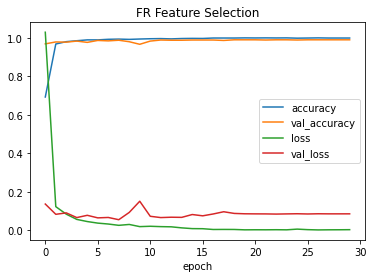

In [141]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [142]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [143]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [144]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.08517025411128998
Test accuracy: 0.9900000095367432
accuracy: 99.00%
